# W-net supervised & apply to unsupervised

## Data

In [5]:
from google.colab import files
from google.colab import auth
auth.authenticate_user()

In [6]:
def importFromDrive(filename, nameId):
  import io
  from googleapiclient.http import MediaIoBaseDownload, MediaFileUpload
  
  from googleapiclient.discovery import build
  drive_service = build('drive', 'v3')
  
  request = drive_service.files().get_media(fileId=nameId)
  variable = io.FileIO(filename, 'wb')
  downloader = MediaIoBaseDownload(variable, request)
  done = False
  while done is False:
    # _ is a placeholder for a progress object that we ignore.
    # (Our file is small, so we skip reporting progress.)
    _, done = downloader.next_chunk()

  variable.seek(0)

In [7]:
importFromDrive('trainSet.mat', '19vro2YKFiURqqmFGYYIx0ZDkirn4F9mk')
importFromDrive('testSet.mat', '1Gmb5aFWuR8kmfDjulgN2h90FutCxQVmF')
importFromDrive('original.zip', '16ibmmBvAYsw9ztlO6KpccQDAzvulEADX')
importFromDrive('binary_images.zip', '1A1sT2-QNEYFvvjcRNSpwavSkTYRKbouY')
importFromDrive('segmented_onehot.zip', '16b1Xej2t3XqpyaaxJIa9VT0jsUurtXvY')
importFromDrive('test_ids_rare.csv', '1Len9VcuimKZ9_WwKozbtf6zQcdOLHheJ')
importFromDrive('classes.csv', '1V34MJgrbcRkoZBFdI-JuVtyAVAx39Oac')
importFromDrive('wnet_sup.hdf5', '1qurNrk9yralCOmtOjgcp9Uy0DNWRuLVD')
importFromDrive('wnet_sup_multi.hdf5', '182M_0EphSZ3ClUKTfChMgOru-cYPAQBh')

In [ ]:
!rm -r data/original data
!unzip original.zip -d data/
!unzip binary_images.zip -d data/
!unzip segmented_onehot.zip -d data/

## Prepare data

In [9]:
import scipy.io
train_ids = scipy.io.loadmat('trainSet.mat', squeeze_me=True)
test_ids = scipy.io.loadmat('testSet.mat', squeeze_me=True)
train_ids = train_ids['TrainingSet']
test_ids = test_ids['TestSet']

In [10]:
import pandas as pd
rare_ids=pd.read_csv('test_ids_rare.csv', header=None)
rare_ids = rare_ids[0].values.tolist()
train_ids = [id_ for id_ in train_ids if id_ not in rare_ids]

In [11]:
classes_ids = pd.read_csv('classes.csv', header=None)
classes_ids = classes_ids.values
classes_ids = classes_ids.squeeze()
total_classes = classes_ids.shape[0]
for i in range(0,classes_ids.shape[0]):
  classes_ids[i] = classes_ids[i].replace('/', '_')

In [12]:
classes = {}
for i in range(classes_ids.shape[0]):
  classes[classes_ids[i]] = (i+1)*3

In [13]:
import scipy.io
import keras
from keras import losses
from keras.layers.convolutional import Conv2D ,SeparableConv2D 
import os
import random
import sys
import warnings
import numpy as np
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import Progbar
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
import scipy.misc
from skimage import io; io.use_plugin('matplotlib')
from skimage.measure import label
import sklearn.preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from keras.backend import int_shape
from keras import backend as K
from scipy import sparse
from skimage import img_as_bool
import cv2
import matplotlib.pyplot as plt
# Setting seed for reproducability
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [10]:
# Function read train images and mask return as nump array
def read_train_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 2))
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    if os.path.isfile("train_img.npy") and os.path.isfile("train_mask.npy"):
        print("Train file loaded from memory")
        X_train = np.load("train_img.npy")
        Y_train = np.load("train_mask.npy")
        return X_train,Y_train
    a = Progbar(len(train_ids))
    for n, id_ in enumerate(train_ids):
        path = 'data/original/'
        img = imread(path + id_ + '.jpg')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant')
        X_train[n] = img
        path_mask = 'data/binary_images/'
        #path_mask = 'data/binary_mat/'
        mask_ = imread(path_mask + id_ + '.png', flatten=True)
        #mask_ = scipy.io.loadmat(path_mask + id_ + '.mat')
        #mask_ = mask_['annotated'][:,:,0]
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.zeros((IMG_HEIGHT,IMG_WIDTH, 2))
        mask[:,:,0] = mask_[:,:,0]
        mask[:,:,1] = mask_[:,:,0]==0

        #for mask_file in next(os.walk(path + '/masks/'))[2]:
        #    mask_ = imread(path + '/masks/' + mask_file)
        #    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        #    mask = np.maximum(mask, mask_)
        Y_train[n] = mask
        a.update(n)
    np.save("train_img",X_train)
    np.save("train_mask",Y_train)
    return X_train,Y_train

In [11]:
# Function read train images and mask return as nump array
def read_test_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_train = np.zeros((len(rare_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    Y_train = np.zeros((len(rare_ids), IMG_HEIGHT, IMG_WIDTH, 2))
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    if os.path.isfile("test_img.npy") and os.path.isfile("test_mask.npy"):
        print("Train file loaded from memory")
        X_train = np.load("test_img.npy")
        Y_train = np.load("test_mask.npy")
        return X_train,Y_train
    a = Progbar(len(rare_ids))
    for n, id_ in enumerate(rare_ids):
        path = 'data/original/'
        img = imread(path + id_ + '.jpg')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant')
        X_train[n] = img
        path_mask = 'data/binary_images/'
        #path_mask = 'data/binary_mat/'
        mask_ = imread(path_mask + id_ + '.png', flatten=True)
        #mask_ = scipy.io.loadmat(path_mask + id_ + '.mat')
        #mask_ = mask_['annotated'][:,:,0]
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.zeros((IMG_HEIGHT,IMG_WIDTH, 2))
        mask[:,:,0] = mask_[:,:,0]
        mask[:,:,1] = mask_[:,:,0]==0

        #for mask_file in next(os.walk(path + '/masks/'))[2]:
        #    mask_ = imread(path + '/masks/' + mask_file)
        #    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        #    mask = np.maximum(mask, mask_)
        Y_train[n] = mask
        a.update(n)
    np.save("test_img",X_train)
    np.save("test_mask",Y_train)
    return X_train,Y_train

In [13]:
# Function read train images and mask return as nump array
def read_train_data_multi(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3, CLASSES=73):
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1))
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    if os.path.isfile("train_img_segm.npy") and os.path.isfile("train_mask_segm.npy"):
        print("Train file loaded from memory")
        X_train = np.load("train_img_segm.npy")
        Y_train = np.load("train_mask_segm.npy")
        return X_train,Y_train
    a = Progbar(len(train_ids))
    for n, id_ in enumerate(train_ids):
        path = 'data/original/'
        img = imread(path + id_ + '.jpg')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant')
        X_train[n] = img
        path_mask = 'data/segmented_onehot/'
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1))
        for i in range(0,CLASSES):
          fname = path_mask + id_ + '/' + classes_ids[i] + '.png'
          if os.path.isfile(fname):
            mask_ = imread(fname, flatten=True)
            mask_ = mask_/255
            mask_ = mask_*classes[classes_ids[i]]
            mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask
        a.update(n)
    np.save("train_img_segm",X_train)
    np.save("train_mask_segm",Y_train)
    return X_train,Y_train

In [14]:
# Function read train images and mask return as nump array
def read_test_data_multi(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3, CLASSES=73):
    X_train = np.zeros((len(rare_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    Y_train = np.zeros((len(rare_ids), IMG_HEIGHT, IMG_WIDTH, 1))
    print('Getting and resizing test images and masks ... ')
    sys.stdout.flush()
    if os.path.isfile("test_img_segm.npy") and os.path.isfile("test_mask_segm.npy"):
        print("Test file loaded from memory")
        X_train = np.load("test_img_segm.npy")
        Y_train = np.load("test_mask_segm.npy")
        return X_train,Y_train
    a = Progbar(len(rare_ids))
    for n, id_ in enumerate(rare_ids):
        path = 'data/original/'
        img = imread(path + id_ + '.jpg')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant')
        X_train[n] = img
        path_mask = 'data/segmented_onehot/'
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1))
        for i in range(0,CLASSES):
          fname = path_mask + id_ + '/' + classes_ids[i] + '.png'
          if os.path.isfile(fname):
            mask_ = imread(fname, flatten=True)
            mask_ = mask_/255
            mask_ = mask_*classes[classes_ids[i]]
            mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask
        a.update(n)
    np.save("test_img_segm",X_train)
    np.save("test_mask_segm",Y_train)
    return X_train,Y_train

## Loss

In [14]:
#### edited ###

##################### random others 
def binary_crossentropy(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

def one_loss(y_true, y_pred):
  loss = tf.to_float(1, name='loss')
  return loss

###################### centroid ###########################

def features_similarity(u,v):
  c1,c2=u[:3],v[:3]
  iu,ju=u[3],u[4]
  iv,jv=v[3],v[4]
  
  dx=K.square(iu-iv)+K.square(ju-jv)
  dx=tf.to_float(dx)
  di=K.sum(K.square(c1-c2))
  di=tf.to_float(di)
  sigma_col=tf.to_float(5)#was 10
  sigma_pos=tf.to_float(20)#was 4
  d=di/sigma_col+dx/sigma_pos
  return K.exp(-(d))
#   return tf.cond(dx <= 25, lambda: K.exp(-d), lambda:  0.)

def to_features(img):
  X_col=3*img
  X_pos=np.zeros((ROWS,COLS,2))
  for i in range(X_pos.shape[0]):
    X_pos[i,:,0]=float(i+1)/70#ROWS
    X_pos[:,i,1]=float(i+1)/70#COLS
  X_pos=tf.convert_to_tensor(X_pos,dtype='float32')
  
  X=tf.concat([X_col,X_pos],axis=2)
  X=K.reshape(X,(ROWS*COLS,5))
  return X

#X=to_features(img)

def features_similarity_matrix(X):
  print('building similarity matrix')
  W=tf.map_fn(elems=X,
              fn=lambda u: 
              tf.map_fn(elems=X,
                        fn=lambda v: 
                        features_similarity(u,v)),
              dtype='float32')
  #careful, this is lazily evaluated
  return W

def mean(X):
  return K.mean(X,axis=0)
def cov(X,Y):
  return mean((X-mean(X))*(Y-mean(X)))
def var(X):
  return cov(X,X)

def wmean(X,w):
  w_sum=K.sum(w)
#   w_=w/K.sum(w)
  return tf.cond(w_sum <= 0., lambda: tf.zeros_like(X[0]), lambda: K.sum(X*tf.expand_dims(w/w_sum, 1),axis=0) )
def wvar(X,w):
  return wmean(K.square(X-wmean(X,w)),w)

def class_ratio_penalty(r,n_classes):
  return tf.to_float(1.)+K.exp(-r*tf.to_float(n_classes)*tf.to_float(200))

def edges_length(P):
  #make the convolution ourselves
  kernel = np.array([[-1,-2,-1],[-2,12,-2],[-1,-2,-1]])
  convolution=K.zeros((ROWS-2,COLS-2,CLASSES))
  for i in range(3):
    ic=i-1#-1,0,1
    for j in range(3):
      jc=j-1#-1,0,1
      convolution+=kernel[i,j]*P[1+ic:ROWS-1+ic,1+jc:COLS-1+jc,:]
  convolution=K.square(convolution)#make it positive and more exagerated
  return K.sum(convolution)/K.sum(P)#sum in all axis

'''def edges_length(P):
  kernel = np.array([[-1,-2,-1],[-2,12,-2],[-1,-2,-1]])
  convolution=K.zeros((ROWS-2,COLS-2,CLASSES))
  for i in range(3):
    ic=i-1#-1,0,1
    for j in range(3):
      jc=j-1#-1,0,1
      convolution+=kernel[i,j]*P[1+ic:ROWS-1+ic,1+jc:COLS-1+jc,:]
  convolution=K.square(convolution)#make it positive and more exaggerated
  class_mean_lengths=tf.map_fn(elems=np.arange(CLASSES),
                               fn=lambda k: K.sum(convolution[:,:,k])/K.sum(P[:,:,k]),
                               dtype='float32')
  return K.mean(class_mean_lengths)
'''
def centroids_similarity_loss(y_true,y_pred):
  img=y_true[0]
  P=y_pred[0]
  X=to_features(img)
  P=tf.reshape(y_pred[0],[ROWS*COLS,CLASSES])
    
  centroids    = tf.map_fn(elems=np.arange(CLASSES), fn=lambda k: wmean(X,P[:,k]),dtype='float32')#each element is a 5 coord vector RGBIJ
  variances    = tf.map_fn(elems=np.arange(CLASSES), fn=lambda k: wvar(X,P[:,k]), dtype='float32')#each element is a 5 coord vector RGBIJ
  class_ratios = tf.map_fn(elems=np.arange(CLASSES), fn=lambda k: mean(P[:,k]),   dtype='float32')#use this to prevent some classes to take over all pixels
  
  loss = tf.to_float(CLASSES, name='loss')
  for k1 in range(CLASSES):
    centroid1=centroids[k1]
    centroid_inter_similarity_mean=tf.to_float(0)
    for k2 in range(k1+1,CLASSES):
      centroid2=centroids[k2]
      centroid_inter_similarity_mean+=features_similarity(centroid1,centroid2)
    loss+=centroid_inter_similarity_mean*class_ratio_penalty(class_ratios[k1],CLASSES)
    centroid_intra_similarity = K.exp(-K.sum(variances[k1]))#variance is the mean squared distance to the centroid, and similarity is exp(-d**2)
    loss-=centroid_intra_similarity/(centroid_intra_similarity+centroid_inter_similarity_mean)#loss/(20*CLASSES*(CLASSES-1)/2)
  
  return (loss +edges_length(tf.reshape(P,(ROWS,COLS,CLASSES))))/(3*CLASSES*(CLASSES-1)/2)


def centroid_similarity_loss_no_variance(y_true,y_pred):
  img=y_true[0]
  P=y_pred[0]
  X=to_features(img)
  P=tf.reshape(y_pred[0],[ROWS*COLS,CLASSES])
  centroids = tf.matmul(tf.transpose(P),X)/tf.matmul(tf.transpose(P),tf.ones((ROWS*COLS,1)))

  loss = tf.to_float(0, name='loss')
  for k1 in range(CLASSES):
    centroid_inter_similarity_mean=tf.to_float(0)
    for k2 in range(k1+1,CLASSES):
      loss+=features_similarity(centroids[k1],centroids[k2])
  return (loss+edges_length(tf.reshape(P,(ROWS,COLS,CLASSES)))) /(CLASSES*(CLASSES-1)/2)


ROWS = 256
COLS = 256
CLASSES = 2
CHANNELS = 3

## Architecture

In [33]:
#### NEW W ####
CLASSES=2
def get_wnet(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3, k=CLASSES):#(shape, k=10)
#    IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = shape
  keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = Lambda(lambda x: x / 255) (inputs)    
  #1
  rn = keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=25)
  conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
  conv1 = Dropout(0.2)(conv1) 
  conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1)
  p1 = MaxPooling2D((2,2)) (conv1)
  #2
  sconv2 =SeparableConv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  sconv2 = Dropout(0.2)(sconv2) 
  sconv2 =SeparableConv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(sconv2)
  p2 = MaxPooling2D((2,2)) (sconv2)
  #3
  sconv3 = SeparableConv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  sconv3 = Dropout(0.2)(sconv3) 
  sconv3 = SeparableConv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(sconv3)
  p3 = MaxPooling2D((2, 2)) (sconv3)
  #4
  sconv4 = SeparableConv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  sconv4 = Dropout(0.2)(sconv4) 
  sconv4 = SeparableConv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(sconv4)
  p4 = MaxPooling2D((2, 2)) (sconv4)
  #5
  sc5 = SeparableConv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  sc5 = Dropout(0.2)(sc5) 
  sc5 = SeparableConv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(sc5)
  #6
  l6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(sc5)
  l6 = concatenate([sconv4, l6])
  l6 = SeparableConv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l6)
  l6 = Dropout(0.2)(l6) 
  l6 = SeparableConv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l6)
  #7
  l7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(l6)
  l7 = concatenate([sconv3, l7])
  l7 = SeparableConv2D(128 , (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l7)
  l7 = Dropout(0.2)(l7)
  l7 = SeparableConv2D(128 , (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l7)
  #8
  l8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(l7)
  l8 = concatenate([sconv2, l8])
  l8 = SeparableConv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l8)
  l8 = Dropout(0.2)(l8) 
  l8 = SeparableConv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l8)
  #9
  l9 = Conv2DTranspose(32 ,(2, 2), strides=(2, 2), padding='same')(l8)
  l9 = concatenate([conv1, l9])
  l9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (l9)
  l9 = Dropout(0.2)(l9) 
  l9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (l9)
  output = Conv2D(k, (1, 1), activation='softmax', kernel_initializer=rn, padding='same', name='segmentation') (l9)
  #----------------------------------------------------------------------
  #soft n-cut loss
  #10
  conv10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (output)
  conv10 = Dropout(0.2)(conv10) 
  conv10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv10)
  p10 = MaxPooling2D(pool_size=(2, 2))  (conv10)
  #2+9
  sconv11 = SeparableConv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p10)
  sconv11 = Dropout(0.2)(sconv11) 
  sconv11 = SeparableConv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(sconv11)
  p11 = MaxPooling2D(pool_size=(2, 2))  (sconv11)
  #3+9
  sconv12 = SeparableConv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p11)
  sconv12 = Dropout(0.2)(sconv12) 
  sconv12 = SeparableConv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(sconv12)
  p12 = MaxPooling2D(pool_size=(2, 2))  (sconv12)
  #4+9
  sconv13 = SeparableConv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p12)
  sconv13 = Dropout(0.2)(sconv13) 
  sconv13 = SeparableConv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(sconv13)
  p13 = MaxPooling2D(pool_size=(2, 2)) (sconv13)
  #5+9
  sc14 = SeparableConv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p13)
  sc14 = Dropout(0.2)(sc14)
  sc14 = SeparableConv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(sc14)
  #6+9
  l15 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(sc14)
  l15 = concatenate([sconv13, l15])
  l15 = SeparableConv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l15)
  l15 = Dropout(0.2)(l15) 
  l15 = SeparableConv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l15)
  #7+9
  l16 = Conv2DTranspose(128,(2, 2), strides=(2, 2), padding='same')(l15)
  l16 = concatenate([sconv12, l16])
  l16 = SeparableConv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l16)
  l16 = Dropout(0.2)(l16) 
  l16 = SeparableConv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l16)
  #8+9
  l17 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(l16)
  l17 = concatenate([sconv11, l17])
  l17 = SeparableConv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l17)
  l17 = Dropout(0.2)(l17) 
  l17 = SeparableConv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l17)
  #9+9
  l18 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(l17)
  l18 = concatenate([conv10, l18])
  l18 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (l18)
  l18 = Dropout(0.2)(l18) 
  l18 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (l18)
  outputs = Conv2D(3, (1, 1), activation='sigmoid', kernel_initializer='he_normal', padding='same', name='reconstruction') (l18)
  Adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.03)
  model = Model(inputs=[inputs], outputs=[output, outputs])
  model.compile(optimizer=Adam,loss={'segmentation': 'binary_crossentropy', 'reconstruction': 'binary_crossentropy'}, metrics=['accuracy'])
  return model

In [34]:
w_net = get_wnet()

## Experiments

### Postprocessing and segmentation visualization

In [17]:
def to_hard_segm_np(P):
  P_hard=np.zeros_like(P)
  for k in range(CLASSES):
    for i in range(ROWS):
      for j in range(COLS):
        P_hard[i,j,np.argmax(P[i,j])]=1
  return P_hard

def to_features_np(img):
  X_col=img
  X_pos=np.zeros((ROWS,COLS,2))
  for i in range(X_pos.shape[0]):
    X_pos[i,:,0]=float(i+1)/ROWS
    X_pos[:,i,1]=float(i+1)/COLS
  
  X=np.concatenate([X_col,X_pos],axis=2)
  X=np.reshape(X,(ROWS*COLS,5))
  return X

def paint_soft_centroid_color(img,P):
  P_vec=P.reshape((ROWS*COLS,P.shape[2]))
  X_np=to_features_np(img)
  centroids = P_vec.T.dot(X_np)/(P_vec.T.dot(np.ones((COLS*ROWS,1))))
  painted_img = np.array([centroids[np.argmax(P_vec[i])][:3] for i in range(ROWS*COLS)]).reshape(ROWS,COLS,CHANNELS)
  return painted_img

def paint_hard_centroid_color(img,P):
  P_hard=to_hard_segm_np(np.reshape(P,(ROWS,COLS,CLASSES)))
  return paint_soft_centroid_color(img,P_hard)

def plot_probabilities(img,P):
  P_vec=P.reshape((ROWS*COLS,CLASSES))
  X_np=to_features_np(img)
  centroids = P_vec.T.dot(X_np)/(P_vec.T.dot(np.ones((COLS*ROWS,1))))
  
  height=5
  plt.figure(figsize=(height,CLASSES*height))
  for k in range(CLASSES):
    plt.subplot(1,CLASSES,k+1)
    class_k_img=np.array([P_vec[i,k] for i in range(ROWS*COLS)]).reshape(ROWS,COLS)
    plt.imshow(class_k_img)
    plt.title('class '+str(k+1)+' probability'),plt.xticks([]), plt.yticks([])
  plt.show()

def plot_winners(img,P):
  P_vec=P.reshape((ROWS*COLS,CLASSES))
  X_np=to_features_np(img)
  centroids = P_vec.T.dot(X_np)/(P_vec.T.dot(np.ones((COLS*ROWS,1))))
  height=5
  plt.figure(figsize=(height,CLASSES*height))
  for k in range(CLASSES):
    plt.subplot(1,CLASSES,k+1)
    class_k_img=np.array([(np.argmax(P_vec[i])==k) for i in range(ROWS*COLS)]).reshape(ROWS,COLS)
    
    plt.imshow(class_k_img)
    plt.title('class '+str(k+1)+' winners'),plt.xticks([]), plt.yticks([])
  plt.show()

'''Post-processing Function'''
def connectivity_split(img,P):
  '''Split each class into as many connected components it has'''
  P_vec=P.reshape((ROWS*COLS,CLASSES))
  P_new_classes=[]
  for k in range(CLASSES):
    #get the pixels where class k has higher probability than the rest of classes
    class_k_img=np.array([(np.argmax(P_vec[i])==k) for i in range(ROWS*COLS)]).reshape(ROWS,COLS)    
    #assign a label to each connected component
    label_array=label(class_k_img,background=0)
    
    #one hot
    label_list = label_array.reshape(ROWS*COLS)
    n_labels=max(label_list)+1
    label_binarizer = sklearn.preprocessing.LabelBinarizer()
    label_binarizer.fit(range(n_labels))
    one_hot = label_binarizer.transform(label_list)
    if n_labels==2:
      one_hot = np.hstack((one_hot, 1 - one_hot))
    one_hot=one_hot.reshape(ROWS,COLS,n_labels)
    one_hot=one_hot[:,:,1:]#delete background class
    P_new_classes.append(one_hot)
  P_new_classes=np.concatenate(P_new_classes,axis=-1)
  
  return paint_soft_centroid_color(img,P_new_classes)

def paints(img,P,rec):  
  plt.figure(figsize=(20,60))
  plt.subplot(1,4,1)
  plt.imshow(img)
  plt.title('original image'),plt.xticks([]), plt.yticks([])

  plt.subplot(1,4,2)
  painted_img = paint_hard_centroid_color(img,P)
  plt.imshow(painted_img)
  plt.title('hard centroid color'),plt.xticks([]), plt.yticks([])
  
  painted_img = connectivity_split(img,P)
  if painted_img is not None:
    plt.subplot(1,4,3)
    plt.imshow(painted_img)
    plt.title('postprocessed'),plt.xticks([]), plt.yticks([])
    
  plt.subplot(1,4,4)
  plt.imshow(rec)
  plt.title('reconstruction'),plt.xticks([]), plt.yticks([])

  plot_probabilities(img,P)
  plot_winners(img,P)
  plt.show()
  
  
'''3D paint '''  
def paint_hard_centroid_color_img(img,P):
  P_hard=to_hard_segm_np(np.reshape(P,(ROWS,COLS,CLASSES)))
  P_vec=P_hard.reshape((ROWS*COLS,CLASSES))
  X_np=to_features_np(img)
  centroids = P_vec.T.dot(X_np)/(P_vec.T.dot(np.ones((COLS*ROWS,1))))
  painted_img = np.array([centroids[np.argmax(P_vec[i])][:3] for i in range(ROWS*COLS)]).reshape(ROWS,COLS,CHANNELS)
  return painted_img


def hard_centroid_pixel_scatter3D(img,P):
  P_hard=to_hard_segm_np(np.reshape(P,(ROWS,COLS,CLASSES)))
  P_vec=P_hard.reshape((ROWS*COLS,CLASSES))
  X_np=to_features_np(img)
  centroids = P_vec.T.dot(X_np)/(P_vec.T.dot(np.ones((COLS*ROWS,1))))
  painted_img = np.array([centroids[np.argmax(P_vec[i])][:3] for i in range(ROWS*COLS)]).reshape(ROWS,COLS,CHANNELS)
  colour1 = img.reshape((ROWS*COLS,CHANNELS))
  colour2 = paint_hard_centroid_color_img(img, P).reshape((ROWS*COLS,CHANNELS))
  x = list(img[:,:,0].reshape((ROWS*COLS)))
  y = list(img[:,:,1].reshape((ROWS*COLS)))
  z = list(img[:,:,2].reshape((ROWS*COLS)))
  fig = plt.figure(figsize=(30,15))
  plt.title('original colours'),plt.xticks([]), plt.yticks([])
  ax1 = fig.add_subplot(121, projection='3d')
  ax1.scatter3D(x, y, z,c=colour1)
  plt.title('original hard'),plt.xticks([]), plt.yticks([])
  ax2 = fig.add_subplot(122, projection='3d')
  ax2.scatter3D(x, y, z,c=colour2)
  plt.show()

### IOU

In [18]:
def IOU(truth, segm):
  if truth.shape != segm.shape:
    print("Groud truth and segmented image should have the same size.")
    return
  truth = truth/np.max(truth)
  segm = segm/np.max(segm)
  intersection = np.logical_and(truth, segm)
  inter_count = np.sum(intersection)
  union = np.logical_or(truth, segm)
  union_count = np.sum(union)
  iou = inter_count/union_count
  return iou
  
def mean_IOU(truth, segm):
  if truth.shape != segm.shape:
    print("Groud truth and segmented images should have the same size.")
    return
  nb_img = truth.shape[0]
  sum_iou = 0
  for i in range(nb_img):
    sum_iou = sum_iou + IOU(truth[i], segm[i])
  mean_iou = sum_iou/nb_img
  return mean_iou

def get_connectivity_split(img,P):
  '''Split each class into as many connected components it has'''
  P_vec=P.reshape((ROWS*COLS,CLASSES))
  P_new_classes=[]
  for k in range(CLASSES):
    #get the pixels where class k has higher probability than the rest of classes
    class_k_img=np.array([(np.argmax(P_vec[i])==k) for i in range(ROWS*COLS)]).reshape(ROWS,COLS)    
    #assign a label to each connected component
    label_array=label(class_k_img,background=0)
    
    #one hot
    label_list = label_array.reshape(ROWS*COLS)
    n_labels=max(label_list)+1
    label_binarizer = sklearn.preprocessing.LabelBinarizer()
    label_binarizer.fit(range(n_labels))
    one_hot = label_binarizer.transform(label_list)
    if n_labels==2:
      one_hot = np.hstack((one_hot, 1 - one_hot))
    one_hot=one_hot.reshape(ROWS,COLS,n_labels)
    one_hot=one_hot[:,:,1:]#delete background class
    P_new_classes.append(one_hot)
  P_new_classes=np.concatenate(P_new_classes,axis=-1)
  return P_new_classes

def get_best_component_iou(img, truth, P):
  best = 0
  for k in range(P.shape[2]):
    iou = IOU(truth, P[:,:,k])
    if(iou > best):
      best = iou
  return best

def get_best_component(img, truth, P):
  best = 0
  segm = P[:,:,0]
  for k in range(P.shape[2]):
    iou = IOU(truth, P[:,:,k])
    if(iou > best):
      best = iou
      segm = P[:,:,k]
  return segm

def segmentation_IOU(img, segm, i):
  n = 256
  m = 256
  original_mask = 'data/segmented_onehot/'
  mean_IOU = 0
  img_id = test_ids[i]
  count = 0
  sum_IOU = 0
  for j in range(len(classes_ids)):
    fname = original_mask + img_id + '/' + classes_ids[j] + '.png'
    if os.path.isfile(fname):
      truth = imread(fname, flatten=True)
      truth = resize(truth, (256,256), mode='constant', preserve_range=False)
      P = get_connectivity_split(img, segm)
      best_segm = get_best_component_iou(img, truth, P)
      count = count+1
      sum_IOU = sum_IOU + best_segm
  sum_IOU = sum_IOU/count
  mean_IOU = mean_IOU+sum_IOU
  return mean_IOU

### Plot contours

In [19]:
def draw_contours(img, mask_, color):
  mask_2 = np.copy(mask_)
  if(mask_2.ndim == 2):
    mask = np.zeros((img.shape[0],img.shape[1],3))
    integer = 1
    if np.max(mask_2) == 1:
      integer = 255
    mask[:,:,0] = mask_2*integer
    mask[:,:,1] = mask_2*integer
    mask[:,:,2] = mask_2*integer
  else:
    mask = mask_2
    
  mask=mask.astype(np.uint8)
  imgray = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
  ret,thresh = cv2.threshold(imgray,127,255,0)
  mask2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  
  img2 = cv2.drawContours(img, contours, -1, color, 15)
  
  return img2

def contours_segmentation(img, mask):
  colors = [(230, 25, 75)	, (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240)]
  for i in range(mask.shape[2]):
    img = draw_contours(np.copy(img), np.copy(mask[:,:,i]), colors[i])
  return img

def plot_comparison_contours(img_id, P):
  original = 'data/original/' + img_id + '.jpg'
  original_mask = 'data/segmented_onehot/' + img_id
  
  original_img = imread(original)
  n = original_img.shape[0]
  m = original_img.shape[1]
  count = 0
  ids_class = []
  ids_class_num = []
  for i in range(len(classes_ids)):
    fname = original_mask + '/' + classes_ids[i] + '.png'
    if os.path.isfile(fname):
      ids_class.append(fname)
      ids_class_num.append(i)
      count = count+1
  mask_truth = np.zeros((n,m,count))   
  mask_segm = np.zeros((n,m,count))
  for i in range(count):
    truth = imread(ids_class[i])
    segm_ = get_best_component(resize(original_img, (256, 256), mode='constant') , resize(truth, (256, 256), mode='constant'), P)
    segm = np.zeros((256,256,3))
    segm[:,:,0] = segm_
    segm[:,:,1] = segm_
    segm[:,:,2] = segm_
    segm = resize(segm, original_img.shape, mode='constant', preserve_range= False)
    mask_truth[:,:,i] = truth
    mask_segm[:,:,i] = segm[:,:,0]
  
  img_truth = contours_segmentation(original_img, mask_truth)
  img_unet = contours_segmentation(original_img, mask_segm)

  plt.figure(figsize=(10,15))
  plt.subplot(121),plt.imshow(np.amax(mask_truth, axis=2))
  plt.title('truth'), plt.xticks([]), plt.yticks([])
  plt.subplot(122),plt.imshow(np.amax(mask_segm, axis=2))
  plt.title('segm'), plt.xticks([]), plt.yticks([])
  
  plt.figure(figsize=(20,25))
  plt.subplot(131),plt.imshow(original_img)
  plt.title('Original'), plt.xticks([]), plt.yticks([])
  plt.subplot(132),plt.imshow(img_truth)
  plt.title('Ground truth'), plt.xticks([]), plt.yticks([])
  plt.subplot(133),plt.imshow(img_unet)
  plt.title('W-net'), plt.xticks([]), plt.yticks([])

  plt.show()

### Obtain train and test data

In [20]:
train_img,train_mask = read_train_data()
test_img, test_mask = read_test_data()

Getting and resizing train images and masks ... 
100/101 [============================>.] - ETA: 0s

In [19]:
train_img,train_mask = read_train_data_multi()
test_img, test_mask = read_test_data_multi()

Getting and resizing train images and masks ... 
100/101 [============================>.] - ETA: 0s

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


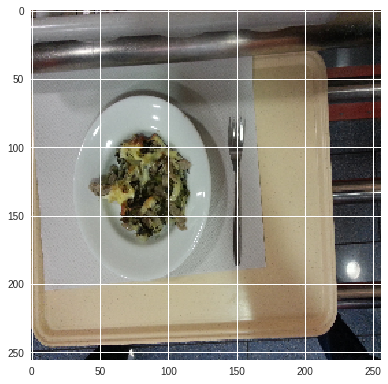

In [61]:
imshow(train_img[5])

## Binary

In [35]:
w_net.load_weights('wnet_sup.hdf5')

### training

In [102]:
print("\nTraining...")
epochs = 25
model_checkpoint = ModelCheckpoint('wnet_sup.hdf5', monitor='loss',verbose=1, save_best_only=True)
history = w_net.fit(train_img,[train_mask, train_img],batch_size=5,epochs=epochs, callbacks=[model_checkpoint])


Training...
Epoch 1/25
551/551 [==============================] - 77s 141ms/step - loss: 0.7884 - segmentation_loss: 0.1499 - reconstruction_loss: 0.6385 - segmentation_acc: 0.9556 - reconstruction_acc: 0.0019

Epoch 00001: loss improved from inf to 0.78844, saving model to wnet_sup.hdf5
Epoch 2/25
551/551 [==============================] - 77s 140ms/step - loss: 0.7874 - segmentation_loss: 0.1492 - reconstruction_loss: 0.6382 - segmentation_acc: 0.9559 - reconstruction_acc: 0.0019

Epoch 00002: loss improved from 0.78844 to 0.78741, saving model to wnet_sup.hdf5
Epoch 3/25
145/551 [======>.......................] - ETA: 56s - loss: 0.7855 - segmentation_loss: 0.1465 - reconstruction_loss: 0.6391 - segmentation_acc: 0.9567 - reconstruction_acc: 0.0021551/551 [==============================] - 77s 140ms/step - loss: 0.7859 - segmentation_loss: 0.1480 - reconstruction_loss: 0.6379 - segmentation_acc: 0.9564 - reconstruction_acc: 0.0019

Epoch 00003: loss improved from 0.78741 to 0.78594

260/551 [=============>................] - ETA: 40s - loss: 0.7695 - segmentation_loss: 0.1339 - reconstruction_loss: 0.6356 - segmentation_acc: 0.9606 - reconstruction_acc: 0.0019551/551 [==============================] - 77s 141ms/step - loss: 0.7755 - segmentation_loss: 0.1400 - reconstruction_loss: 0.6355 - segmentation_acc: 0.9584 - reconstruction_acc: 0.0019

Epoch 00025: loss did not improve from 0.77543


In [104]:
def drive_download(input_file_name,output_folder_id=None):
  # Install the PyDrive wrapper & import libraries.
  # This only needs to be done once in a notebook.
  !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  
  # Authenticate and create the PyDrive client.
  # This only needs to be done once in a notebook.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  
  # Create & upload a file.
  options = {'title': input_file_name}
  if output_folder_id is not None:
    options['parents']=[{'id': output_folder_id}]
  uploaded = drive.CreateFile(options)
  uploaded.SetContentFile(input_file_name)
  uploaded.Upload()
  print('Drive file ID {}'.format(uploaded.get('id')))
  return uploaded.get('id')
  
drive_download(input_file_name='wnet_sup.hdf5',output_folder_id='1rOi0YK3txbdYYIaSwdqt2dfZVr8cejXM')

Drive file ID 1qurNrk9yralCOmtOjgcp9Uy0DNWRuLVD


'1qurNrk9yralCOmtOjgcp9Uy0DNWRuLVD'

### Supervised W-net results

In [36]:
test_images=[]
for i in [0,1,2,3,4,5,6,7]:  
  imgee = np.zeros((1,256,256,3))
  im = imread('data/original/' + test_ids[i] + '.jpg')[:,:,:3]
  im = resize(im, (256, 256), mode='constant')
  imgee[0] = im
  y_s = w_net.predict(imgee,batch_size=1)
  segm = y_s[0][0]
  rec = y_s[1][0]
  paints(imgee[0],segm,rec)
  test_images.append(segm)

#### IoU

In [37]:
suma = 0
for i in [0,1,2,3,4,5,6,7]: 
  im = imread('data/original/' + test_ids[i] + '.jpg')[:,:,:3]
  im = resize(im, (256, 256), mode='constant') 
  len(test_images)
  suma = suma+segmentation_IOU(im, test_images[i], i)
print("IOU for supervised W-net: {}".format(suma/8))

IOU for supervised W-net: 0.6508081038780983


#### Contour plot

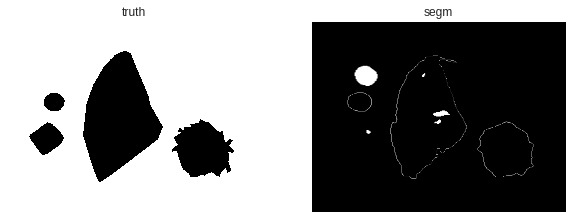

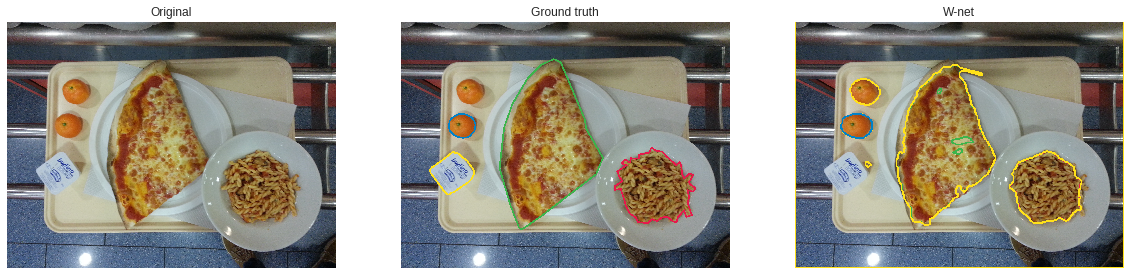

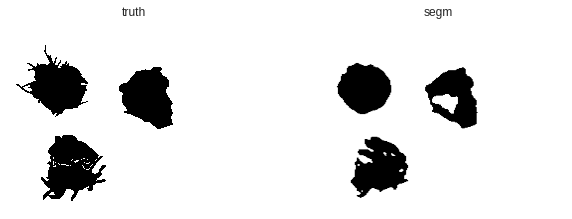

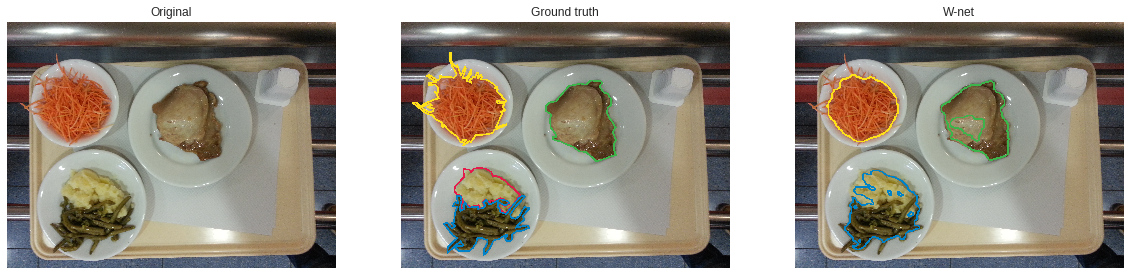

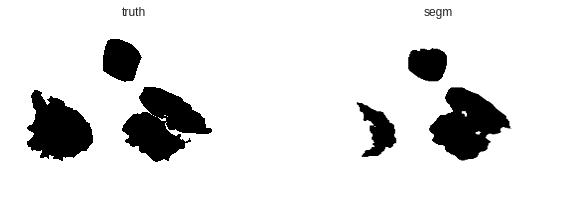

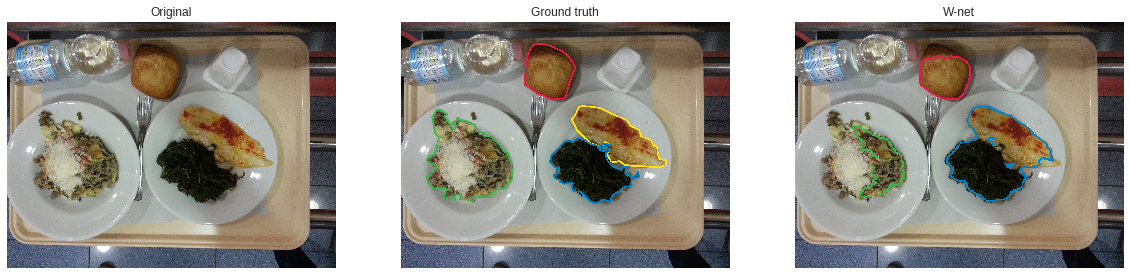

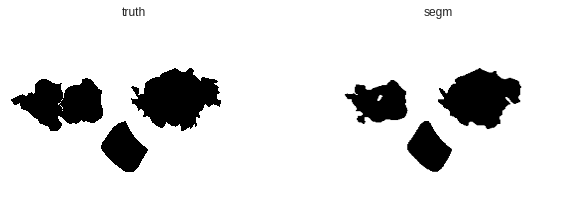

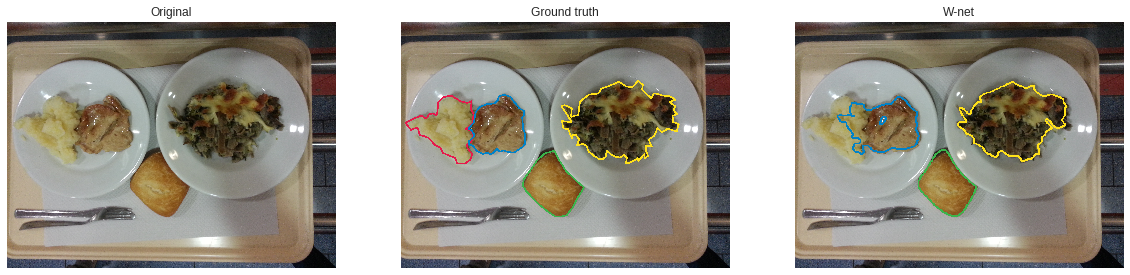

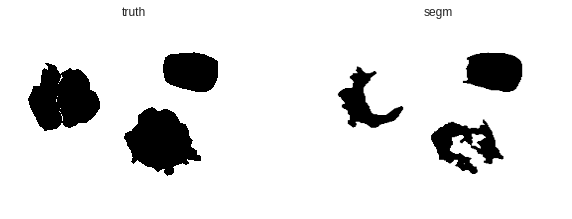

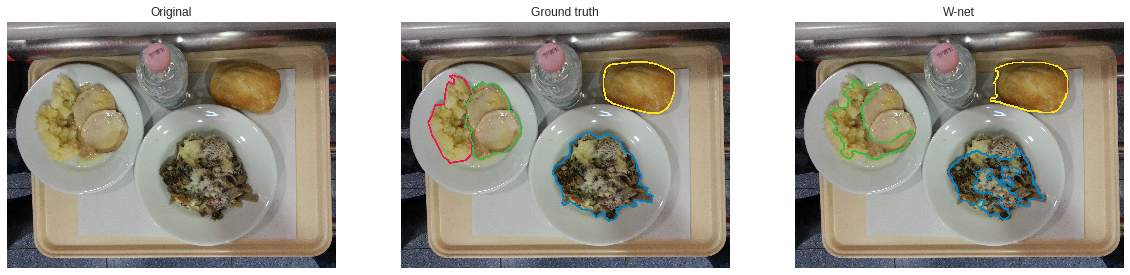

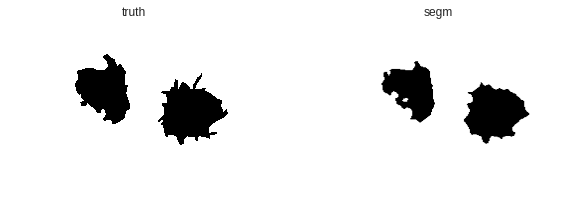

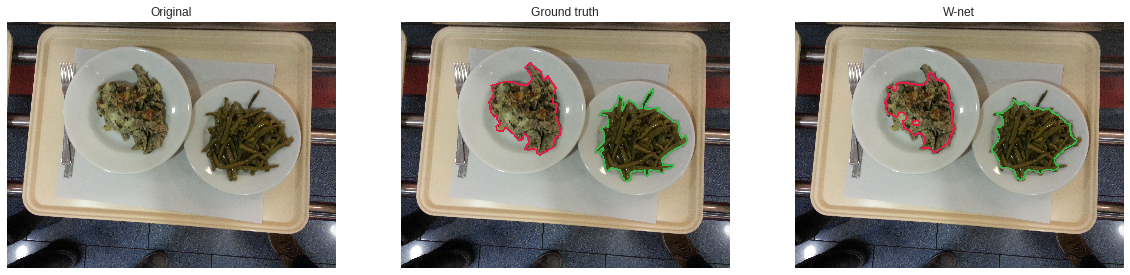

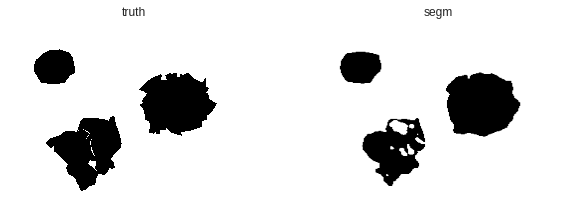

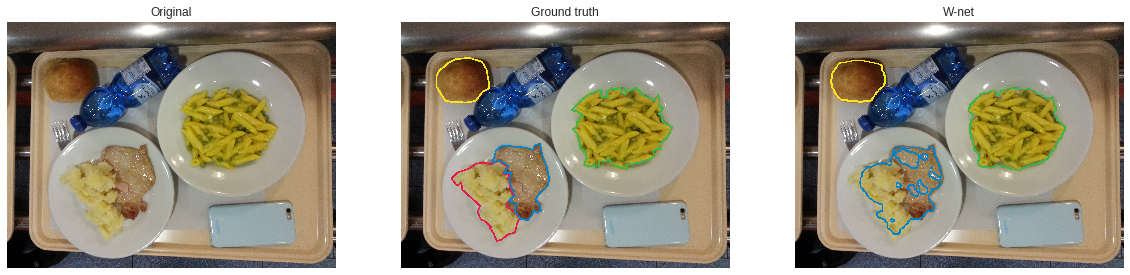

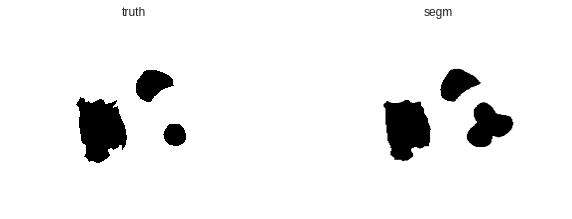

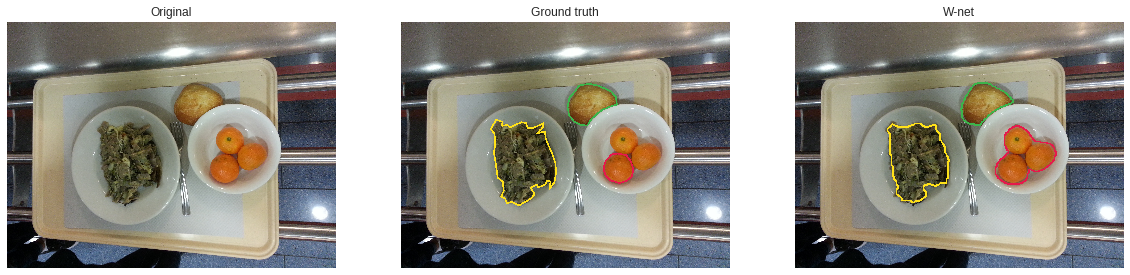

In [38]:
for i in [0,1,2,3,4,5,6,7]: 
  im = imread('data/original/' + test_ids[i] + '.jpg')[:,:,:3]
  im = resize(im, (256, 256), mode='constant') 
  P = get_connectivity_split(im, test_images[i])
  plot_comparison_contours(test_ids[i], P)

### Training with weights from supervised W-net

In [24]:
w_net.load_weights('wnet_sup.hdf5')

In [25]:
img = np.zeros((1,256,256,3))
i=5
im = imread('data/original/' + test_ids[0] + '.jpg')[:,:,:3]
im = resize(im, (256, 256), mode='constant')
img[0] = im

In [27]:
segmentation1 = []
reconstruction1 = []
suma1 = []
for i in range(400):
  history = w_net.fit(img[:,:,:,:3],[img,img[:,:,:,:3]],epochs=1, batch_size=1,verbose=0)
  y_s = w_net.predict(img[:,:,:,:3],batch_size=1 , verbose=0)
  segm = y_s[0][0]
  rec = y_s[1][0]
  losses = w_net.evaluate(img[:,:,:,:3],[img,img[:,:,:,:3]], batch_size=1,verbose=0)
  segmentation1.append(losses[1])
  reconstruction1.append(losses[2])
  suma1.append(losses[0])
  if i%10==0:
    print(i)
    paints(img[0],segm,rec)
plt.plot(segmentation1)
plt.plot(reconstruction1)
plt.plot(suma1)
plt.title('model double loss')
plt.ylabel('losses value')
plt.xlabel('epoch')
plt.legend(['segmentation loss','reconstruction loss','model loss'], loc='upper left')
plt.show()

In [28]:
test_images=[]
for i in [0,1,2,3,4,5,6,7]:  
  imgee = np.zeros((1,256,256,3))
  im = imread('data/original/' + test_ids[i] + '.jpg')[:,:,:3]
  im = resize(im, (256, 256), mode='constant')
  imgee[0] = im
  y_s = w_net.predict(imgee,batch_size=1)
  segm = y_s[0][0]
  rec = y_s[1][0]
  paints(imgee[0],segm,rec)
  test_images.append(segm)

In [32]:
suma = 0
for i in [0,1,2,3,4,5,6,7]: 
  im = imread('data/original/' + test_ids[i] + '.jpg')[:,:,:3]
  im = resize(im, (256, 256), mode='constant') 
  len(test_images)
  suma = suma+segmentation_IOU(im, test_images[i], i)
print("IOU for unsupervised with supervised weights: {}".format(suma/8))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


IOU for unsupervised with supervised weights: 0.06806129373436025


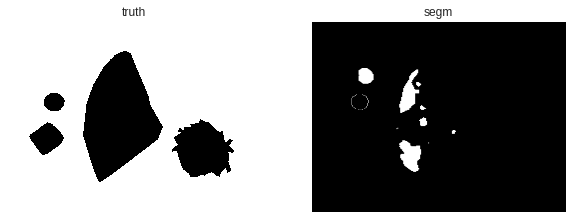

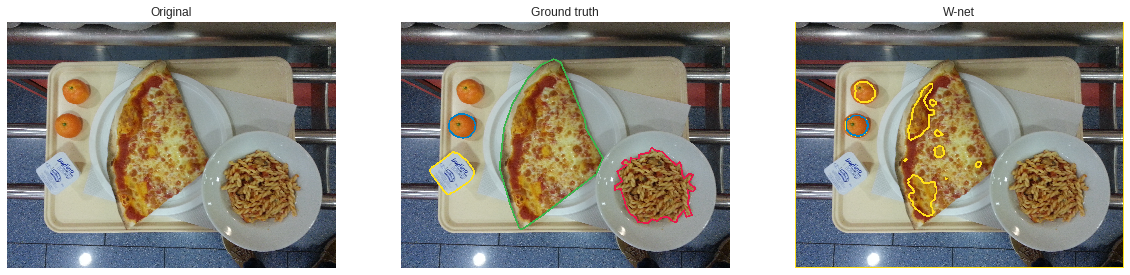

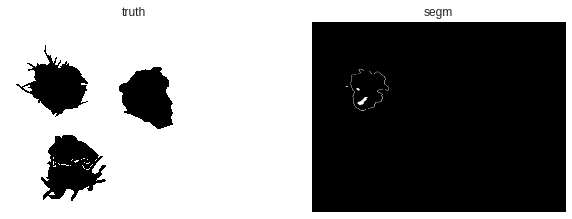

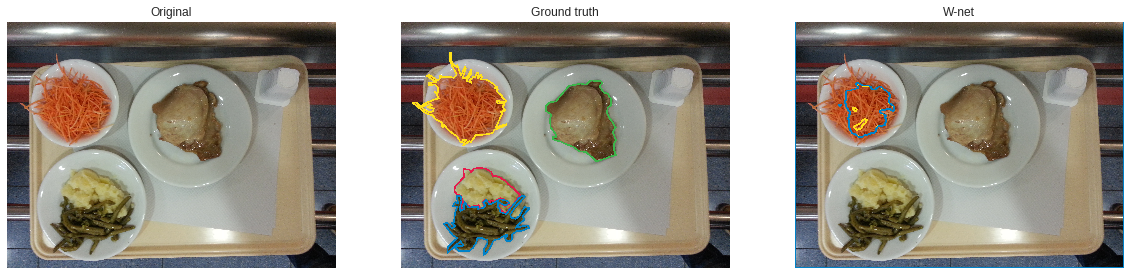

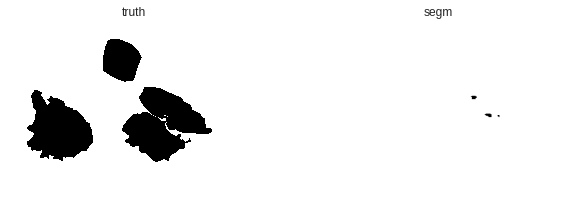

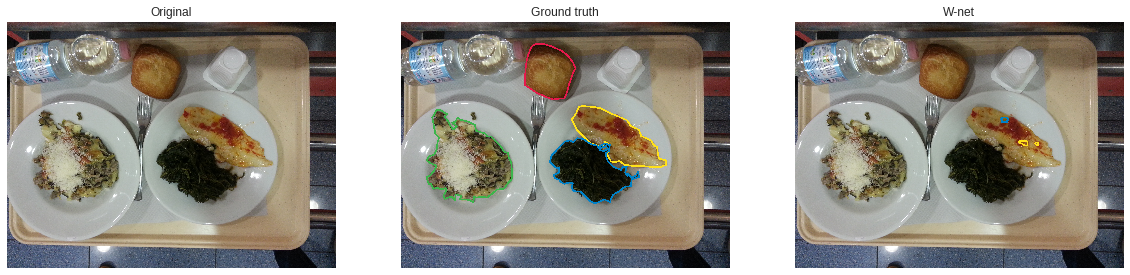

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


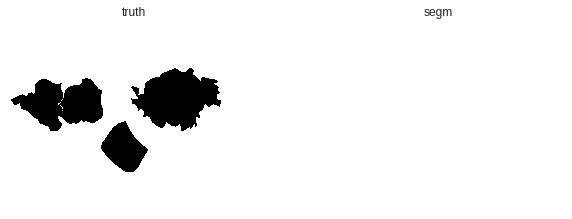

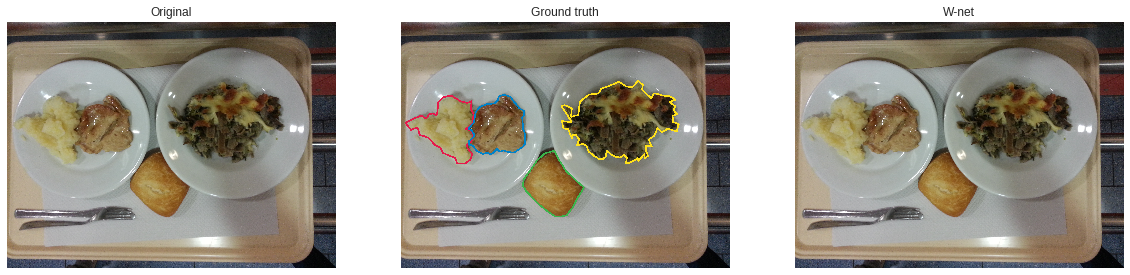

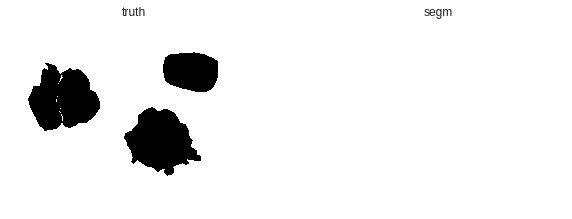

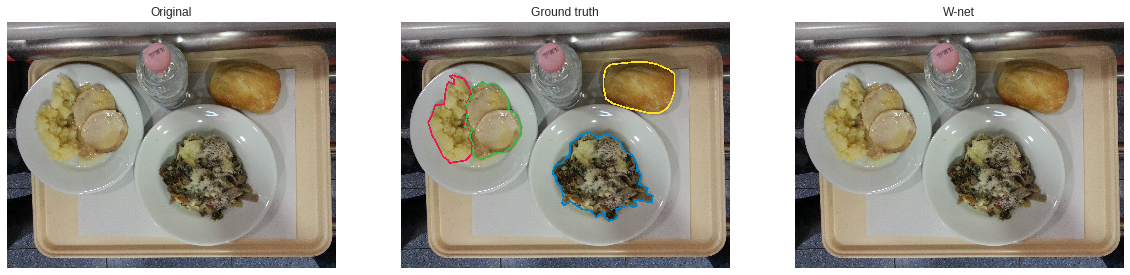

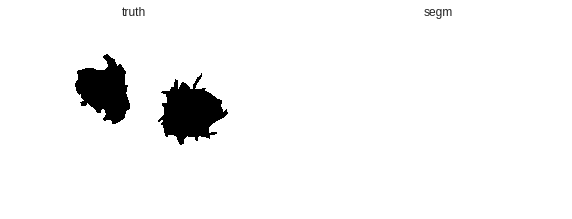

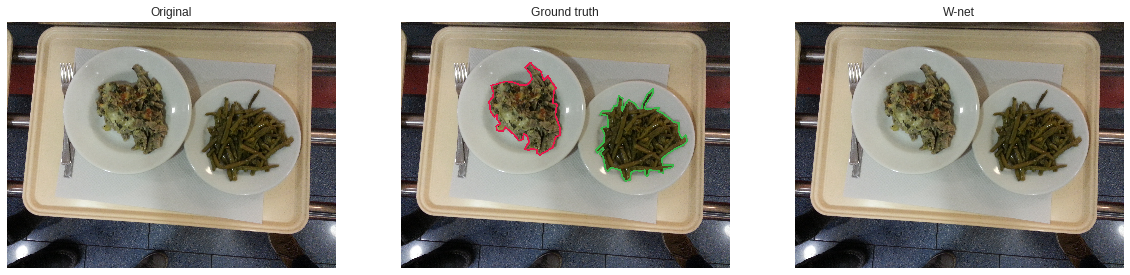

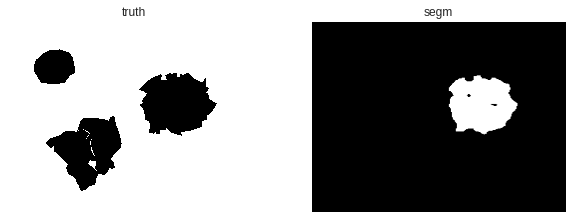

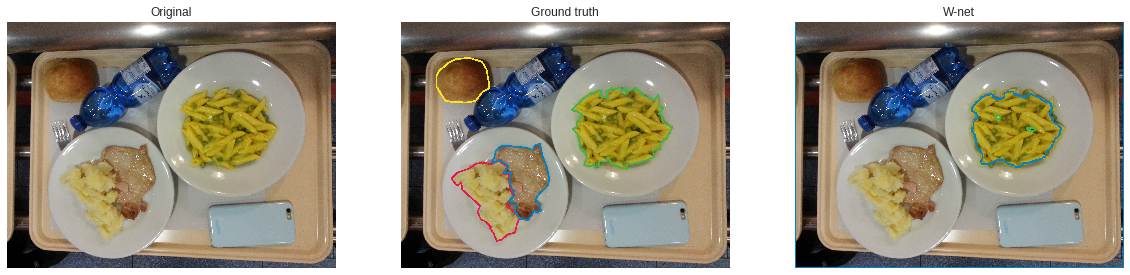

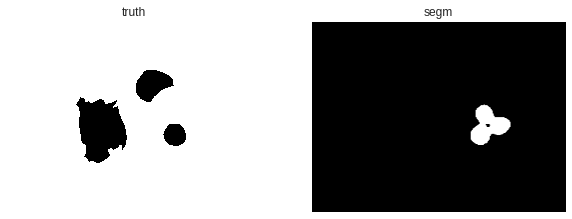

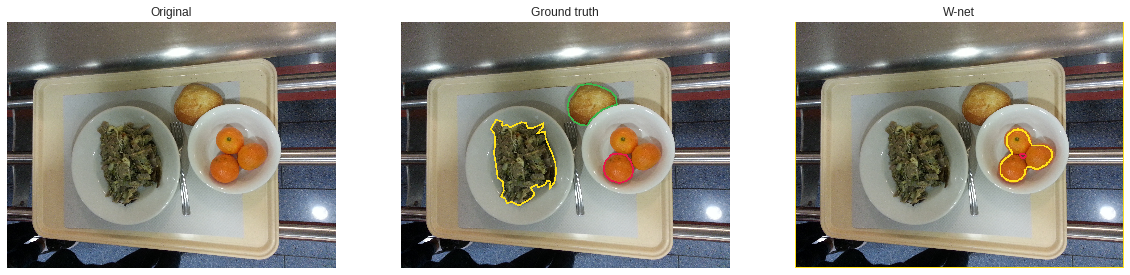

In [31]:
for i in [0,1,2,3,4,5,6,7]: 
  im = imread('data/original/' + test_ids[i] + '.jpg')[:,:,:3]
  im = resize(im, (256, 256), mode='constant') 
  P = get_connectivity_split(img, test_images[i])
  plot_comparison_contours(test_ids[i], P)